In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\domma\Dropbox\Software\CognitiveModels\content"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using Downloads, CSV, DataFrames
using Turing, Distributions
using CairoMakie

df = CSV.read(Downloads.download("https://raw.githubusercontent.com/RealityBending/DoggoNogo/main/study1/data/data_game.csv"), DataFrame)
df

5894×9 DataFrame
  Row │ RT       ISI      Trial  Participant  Session  Threshold  Feedback  Fe ⋯
      │ Float64  Float64  Int64  String7      String3  String7    String15  In ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │   0.517    1.638      1  S002         S1       NA         Positive     ⋯
    2 │   0.433    2.282      2  S002         S1       0.475      Positive
    3 │   0.533    0.739      3  S002         S1       0.494      Negative
    4 │   0.35     0.602      4  S002         S1       0.458      Positive
    5 │   0.517    1.951      5  S002         S1       0.47       Negative     ⋯
    6 │   0.383    0.952      6  S002         S1       0.456      Positive
    7 │   0.383    0.875      7  S002         S1       0.445      Positive
    8 │   0.417    2.662      8  S002         S1       0.442      Positive
    9 │   0.367    2.8        9  S002         S1       0.433      Positive     ⋯
   10 │   0.417    0.258     10  S002         S1       0.432      Positive
   11 │   0.317    2.285     11  S002         S1       0.421      Positive
  ⋮   │    ⋮        ⋮       ⋮         ⋮          ⋮         ⋮         ⋮         ⋱
 5885 │   0.367    2.708    111  S025         S2       0.383      Positive
 5886 │   0.433    0.137    112  S025         S2       0.383      Negative     ⋯
 5887 │   0.3      3.032    113  S025         S2       0.382      Positive
 5888 │   0.3      2.483    114  S025         S2       0.382      Positive
 5889 │   0.45     0.574    115  S025         S2       0.382      Negative
 5890 │   0.25     2.279    116  S025         S2       0.381      Positive     ⋯
 5891 │   0.384    2.789    117  S025         S2       0.381      Negative
 5892 │   0.283    1.743    118  S025         S2       0.38       Positive
 5893 │   0.283    3.268    119  S025         S2       0.38       Positive
 5894 │   0.25     2.987    120  S025         S2       0.378      Positive     ⋯
                                                 2 columns and 5873 rows omitted

In [3]:
@model function model_linear(rt; isi=nothing)

    # Set priors on variance, intercept and effect of ISI
    σ² ~ truncated(Normal(0, 1); lower=0)
    intercept ~ truncated(Normal(0, 1); lower=0)
    slope_isi ~ Normal(0, 0.5)

    for i in 1:length(rt)
        μ = intercept + slope_isi * isi[i]
        rt[i] ~ Normal(μ, σ²)
    end
end

model = model_linear(df.RT, isi=df.ISI)
chain_linear = sample(model, NUTS(), 200)

# Summary (95% CI)
quantile(chain_linear; q=[0.025, 0.975])

┌ Info: Found initial step size
└   ϵ = 0.0015625


Sampling:   0%|█                                        |  ETA: 0:00:48

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Quantiles
  parameters      2.5%     97.5% 
      Symbol   Float64   Float64 

          σ²    0.0653    0.0718
   intercept    0.3428    0.3492
   slope_isi   -0.0220   -0.0187


In [4]:
pred = predict(model_linear([(missing) for i in 1:length(df.RT)]; isi=df.ISI), chain_linear)
pred = Array(pred)

200×5894 Matrix{Float64}:
 0.233589  0.216272  0.431348  0.264427  …  0.321158  0.287544  0.356395
 0.159943  0.32831   0.37483   0.331477     0.262541  0.374713  0.343006
 0.339594  0.216965  0.453368  0.360128     0.35188   0.307899  0.408595
 0.346711  0.260868  0.304688  0.31751      0.41447   0.364463  0.279069
 0.415861  0.153747  0.316506  0.324343     0.228155  0.33557   0.293253
 0.306683  0.416249  0.31013   0.412976  …  0.330372  0.383311  0.422424
 0.303473  0.31499   0.420903  0.318579     0.324367  0.24125   0.279402
 0.354338  0.411124  0.347947  0.359534     0.384894  0.233785  0.291247
 0.354251  0.261749  0.339339  0.395916     0.269789  0.472021  0.208359
 0.288891  0.327639  0.205383  0.325412     0.35026   0.311427  0.300746
 0.258879  0.251699  0.324114  0.355416  …  0.197649  0.240118  0.27647
 0.436515  0.156233  0.298025  0.299878     0.395112  0.144632  0.329157
 0.375202  0.3077    0.40231   0.26872      0.328067  0.307384  0.238064
 ⋮                        

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


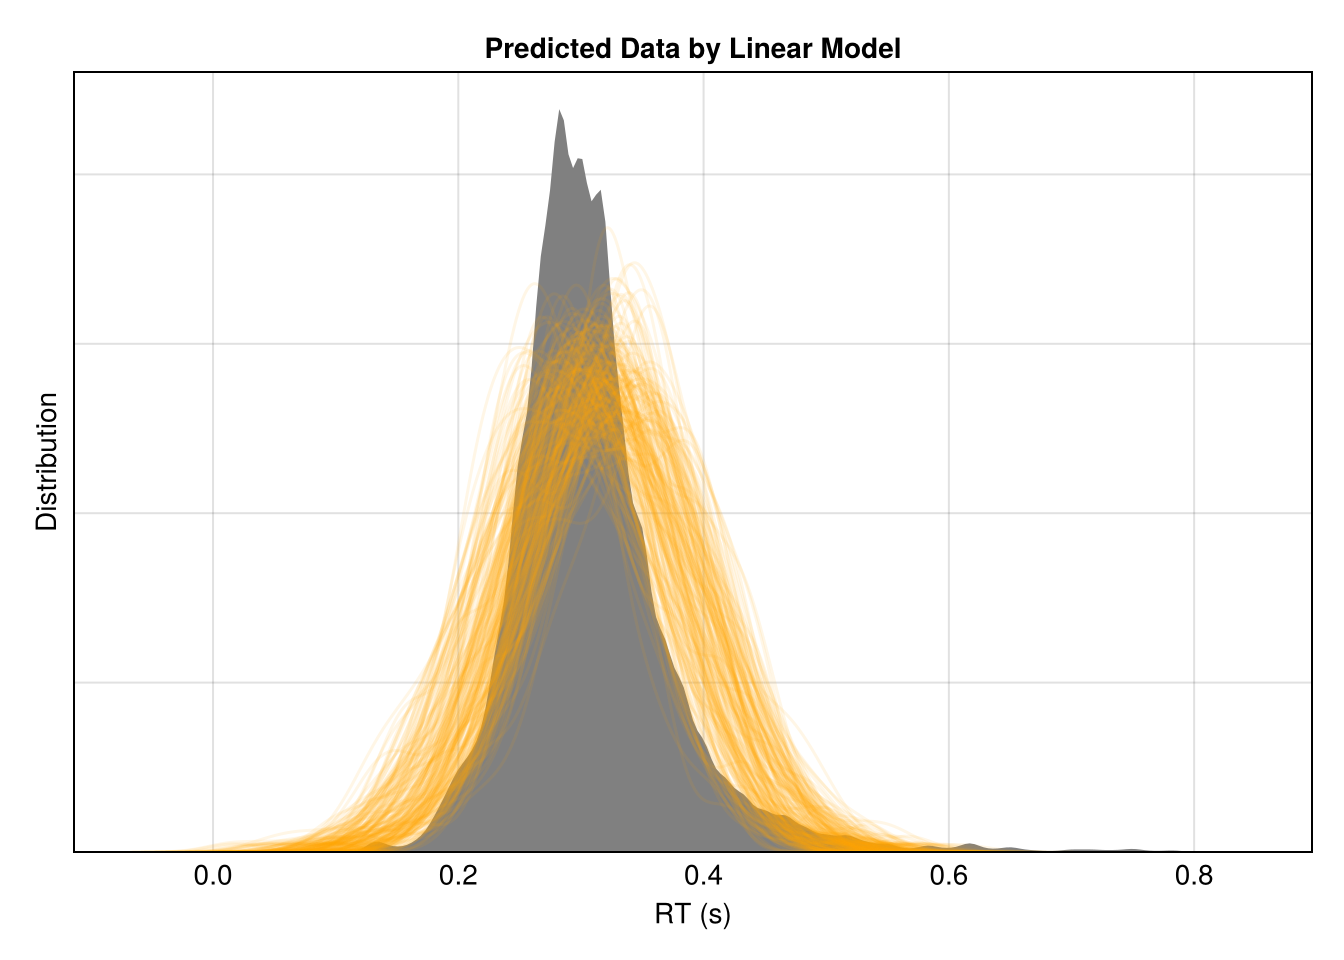

In [5]:
f = Figure()
ax = Axis(f[1, 1], title="Predicted Data by Linear Model",
    xlabel="RT (s)",
    ylabel="Distribution",
    yticksvisible=false,
    xticksvisible=false,
    yticklabelsvisible=false)

CairoMakie.density!(df.RT, color="grey")
for i in 1:length(chain_linear)
    lines!(ax, Makie.KernelDensity.kde(pred[:, i]), color="orange", alpha=0.1)
end
CairoMakie.ylims!(ax, (0, nothing))
f